# VGGFace Fake Face classifier

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# You can add the shortcut for this diectory
%cd /content/drive/MyDrive/COMP4471_project/
!ls

Mounted at /content/drive
/content/drive/MyDrive/COMP4471_project
COMP4471_Fakeface_detector.ipynb  fake-image-classification  vgg-face-classifier.ipynb


In [4]:
%cd /content/drive/MyDrive/COMP4471_project/fake-image-classification/
!ls

/content/drive/MyDrive/COMP4471_project/fake-image-classification
convert_torch.py  models   net.png	real_and_fake_face	      vgg_face_torch
main.ipynb	  net	   __pycache__	real_and_fake_face_detection  vgg_face_torch.tar.gz.1
model.onnx	  net.pdf  README.md	vgg_face.py


In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
path = '/content/drive/MyDrive/COMP4471_project/fake-image-classification/'
image_path = Path(path) / "real_and_fake_face"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory")

/content/drive/MyDrive/COMP4471_project/fake-image-classification/real_and_fake_face directory exists.


In [6]:
train_dir = image_path / "training"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/COMP4471_project/fake-image-classification/real_and_fake_face/training'),
 PosixPath('/content/drive/MyDrive/COMP4471_project/fake-image-classification/real_and_fake_face/test'))

Random image path: /content/drive/MyDrive/COMP4471_project/fake-image-classification/real_and_fake_face/training/fake/easy_225_0010.jpg
Image class: fake
Image height: 600
Image width: 600


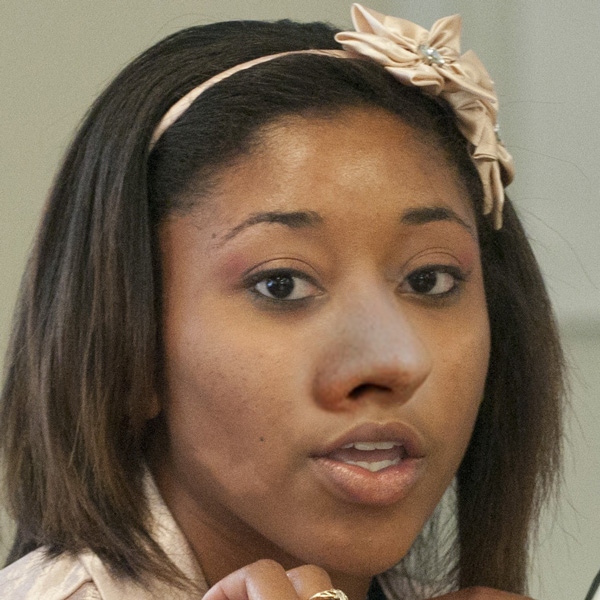

In [8]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)


print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [7]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [10]:
class_names = train_data.classes
class_names

['fake', 'real']

In [8]:
from torch.utils.data.dataloader import default_collate

# torch.multiprocessing.set_start_method('spawn')

train_dataloader = DataLoader(dataset=train_data,
                  batch_size=32,
                  num_workers=1,
                  shuffle=True,
                  pin_memory = True,
                  pin_memory_device = device)

test_dataloader = DataLoader(dataset=test_data,
                batch_size=32,
                num_workers=1,
                shuffle=False,
                pin_memory = True)

In [41]:
for b in train_dataloader:
  input = b[0]
  print(input.device)
  break

cpu


In [32]:
device

'cuda'

# VGG model

In [10]:
# !pip install torchfile
from vgg_face import VGG_16
vgg_face_model = VGG_16().to(device).float()
vgg_face_model.load_weights(path = "./vgg_face_torch/VGG_FACE.t7")

  Preparing metadata (setup.py) ... done
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5694 sha256=31ac72413b5331068ef6af06f2ea331141aa32a1acd051e4f52c4ea5788dd3d8
  Stored in directory: /root/.cache/pip/wheels/c7/e9/87/1c51daf8e468d5c14931f8ac3344880f903ba96b063675cac2
Successfully built torchfile


In [11]:
vgg_face_model

VGG_16(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_3): 

In [18]:
summary(vgg_face_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
            Conv2d-3        [-1, 128, 112, 112]          73,856
            Conv2d-4        [-1, 128, 112, 112]         147,584
            Conv2d-5          [-1, 256, 56, 56]         295,168
            Conv2d-6          [-1, 256, 56, 56]         590,080
            Conv2d-7          [-1, 256, 56, 56]         590,080
            Conv2d-8          [-1, 512, 28, 28]       1,180,160
            Conv2d-9          [-1, 512, 28, 28]       2,359,808
           Conv2d-10          [-1, 512, 28, 28]       2,359,808
           Conv2d-11          [-1, 512, 14, 14]       2,359,808
           Conv2d-12          [-1, 512, 14, 14]       2,359,808
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
           Linear-14                 [-

# Load the vgg-face weight

In [27]:
# !wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
# !tar -xvf vgg_face_torch.tar.gz.1
# !ls

vgg_face_torch/
vgg_face_torch/._ak.png
vgg_face_torch/ak.png
vgg_face_torch/._COPYING
vgg_face_torch/COPYING
vgg_face_torch/demo.lua
vgg_face_torch/names.txt
vgg_face_torch/._README
vgg_face_torch/README
vgg_face_torch/VGG_FACE.t7
convert_torch.py  net	     real_and_fake_face		   vgg_face_torch.tar.gz.1
main.ipynb	  net.pdf    real_and_fake_face_detection
model.onnx	  net.png    vgg_face.py
models		  README.md  vgg_face_torch


# Custom Classifier

In [12]:
class VGGFace_Classifier(nn.Module):
  def __init__(self):
      super(VGGFace_Classifier, self).__init__()
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(25088, 2048)
      self.fc2 = nn.Linear(2048, 1)  # Assuming 2622 output classes for VGG-Face

      self.fc1.apply(self.xavier_init)
      self.fc2.apply(self.xavier_init)

  def forward(self, x):
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.fc2(x)
      return x

  def xavier_init(self, m):
    if isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      m.bias.data.fill_(0.01)


# Fine-tine the model

In [ ]:
# vgg_face_model_state = vgg_face_model.state_dict()
# print(vgg_face_model_state)

In [13]:
custom_vgg_model = torch.nn.Sequential(*(list(vgg_face_model.children()))[:-3])
custom_vgg_model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
custom_vgg_model.classifier = VGGFace_Classifier().to(device)

In [14]:
custom_vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): Ada

In [18]:
from torchsummary import summary
summary(custom_vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
            Conv2d-3        [-1, 128, 224, 224]          73,856
            Conv2d-4        [-1, 128, 224, 224]         147,584
            Conv2d-5        [-1, 256, 224, 224]         295,168
            Conv2d-6        [-1, 256, 224, 224]         590,080
            Conv2d-7        [-1, 256, 224, 224]         590,080
            Conv2d-8        [-1, 512, 224, 224]       1,180,160
            Conv2d-9        [-1, 512, 224, 224]       2,359,808
           Conv2d-10        [-1, 512, 224, 224]       2,359,808
           Conv2d-11        [-1, 512, 224, 224]       2,359,808
           Conv2d-12        [-1, 512, 224, 224]       2,359,808
           Conv2d-13        [-1, 512, 224, 224]       2,359,808
AdaptiveAvgPool2d-14            [-1, 51

# Plot helper funciton

In [19]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Set up optimizaer and Loss function

In [15]:
# Setup loss function and optimization algorithm
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(custom_vgg_model.parameters(), 0.0002)

# Hyperparameters

In [16]:
epochs = 5

# Train/Fine-tune

In [17]:
train_accuaries = []
test_accuaries = []
train_loss = []
test_loss = []

In [18]:
from tqdm.auto import tqdm
torch.manual_seed(42)

In [20]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   7824 MiB |   9984 MiB |  21880 MiB |  14055 MiB |\n|       from large pool |   7823 MiB |   9983 MiB |  21878 MiB |  14055 MiB |\n|       from small pool |      1 MiB |      1 MiB |      1 MiB |      0 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   7824 MiB |   9984 MiB |  21880 MiB |  14055 MiB |\n|       from large pool |   7823 MiB |   9983 MiB |

In [19]:
for epoch in tqdm(range(epochs)):
    custom_vgg_model.train()  # Set the model to training mode
    train_loss = 0.0
    train_acc = 0.0

    # Iterate over the training data
    for batch, (X, y) in enumerate(train_dataloader):
      y_pred = custom_vgg_model(X.to(device))  # Forward pass
      loss = loss_fn(y_pred, y)  # Compute the loss

      # Compute the training accuracy
      preds = torch.eq(y, y_pred.argmax(dim=1)).sum().item()
      acc = preds / y.size(0)

      train_loss += loss.item()
      train_acc += acc

      optimizer.zero_grad()  # Zero the gradients
      loss.backward()  # Backward pass
      optimizer.step()  # Update the weights

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Epoch {epoch + 1}: "
          f"Train Loss: {train_loss :.4f}, "
          f"Train Acc: {train_acc :.4f}")

    train_accuaries.append(train_acc)
    train_loss.append(train_loss)

    # Validation loop
    custom_vgg_model.eval()  # Set the model to evaluation mode
    y_test_loss = 0.0
    y_test_acc = 0.0

    # Iterate over the validation data
    with torch.inference_mode():
      for i, (X, y) in enumerate(test_dataloader):
        y_test_pred = custom_vgg_model(X.to(device))  # Forward pass
        loss = loss_fn(y, y_test_pred)  # Compute the loss

        # Compute the validation accuracy
        preds = torch.eq(y, y_pred.argmax(dim=1)).sum().item()
        acc = preds / y.size(0)

        y_test_loss += loss.item()
        y_test_acc += acc

      y_test_loss /= len(test_dataloader)
      y_test_acc /= len(test_dataloader)
      print(f"Epoch {epoch + 1}"
            f"test Loss: {y_test_loss :.4f}, "
            f"test Acc: {y_test_acc :.4f}")
      test_accuaries.append(y_test_acc)
      test_loss.append(y_test_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
custom_vgg_model.eval()  # Set the model to evaluation mode
y_test_loss = 0.0
y_test_acc = 0.0

with torch.inference_mode():
  for i, (X, y) in enumerate(test_dataloader):
    y_test_pred = custom_vgg_model(X)  # Forward pass
    loss = loss_fn(y, y_test_pred)  # Compute the loss

    # Compute the validation accuracy
    preds = torch.eq(y, y_pred.argmax(dim=1)).sum().item()
    acc = preds / y.size(0)

    y_test_loss += loss.item()
    y_test_acc += acc

  y_test_loss /= len(test_dataloader)
  y_test_acc /= len(test_dataloader)
  print(f"test Loss: {y_test_loss :.4f}, "
            f"test Acc: {y_test_acc :.4f}")

# Loss and accuarcy

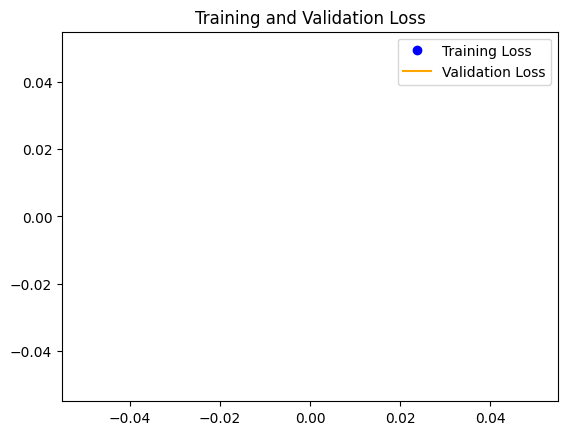

In [25]:
plot_loss(range(1, len(train_loss) + 1), train_loss, test_loss)

In [ ]:
plot_accuracy(range(1, len(train_loss) + 1), train_accuaries, test_accuaries)

# Save the model

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "fake-image-model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=custom_vgg_model.state_dict(), f=MODEL_SAVE_PATH)

# Visualization